In [1]:
import pandas as pd
import numpy as np
import re
import json
import matplotlib.pyplot as plt
import glob, os, csv

import ast
from collections import Counter
from operator import add

from sklearn.model_selection import train_test_split
import math
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction import DictVectorizer
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier, StackingClassifier, AdaBoostClassifier
import seaborn as sns
from sklearn.metrics import classification_report
# from xgboost import XGBClassifier
pd.options.mode.chained_assignment = None

In [2]:
import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


from transformers import RobertaModel, RobertaTokenizer, RobertaForSequenceClassification, RobertaConfig
from transformers import AdamW

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Preprocessing

In [4]:
## Categories ##
# Market: Drug, gun, 
# Counterfeit: counterfeit credit cards, money, ID
# Services: Hosting service, forum, email, pastebin, file-sharing
# Security: Security-related information, tutorials or services, leaked data
# Porn: Hosting pornographic material
# Cryptocurrency
# NoAccess: Login, Down, Empty
# Other: Cannot be classified in any other category (e.g. personal blog)

In [5]:
# Dictionary of conversion of categories
conversion_dict = {
    'Art': 'Other',
    'Casino': 'Services',
    'Counterfeit Credit-Cards': 'Counterfeit',
    'Counterfeit Money': 'Counterfeit',
    'Counterfeit Personal-Identification': 'Counterfeit',
    'Cryptocurrency': 'Cryptocurrency',
    'Cryptolocker': 'Security',
    'Down': 'NoAccess',
    'Drugs': 'Market',
    'Empty': 'NoAccess',
    'Forum': 'Services',
    'Hacking': 'Security',
    'Hosting': 'Services',
    'Leaked-Data': 'Security',
    'Library': 'Other',
    'Locked': 'NoAccess',
    'Marketplace': 'Market',
#     'Onion Directory/Wiki': ['directory', 'dir', 'wiki'],
    'Personal': 'Other',
    'Politics': 'Other',
    'Porno': 'Porn',
    'Religion': 'Other',
    'Services': 'Services',
    'Social-Network': 'Services',
    'Violence': 'Market'
}

In [6]:
# Read input data
df_combined = pd.read_csv('../data/model_training_dataset.csv')

# convert the string representation of a list into a list
df_combined['url'] = df_combined['url'].apply(ast.literal_eval)
df_combined['body_text'] = df_combined['body_text'].apply(ast.literal_eval)
df_combined['body_token'] = df_combined['body_token'].apply(ast.literal_eval)
df_combined['class'] = df_combined['class'].apply(lambda x: x.strip())
df_combined

,url,title,body_text,body_token,language,class
0,[wwjewp6ca4rkudyj.onion],\n Frënn vun der Ënn - Index\n,"[Skip to main content, Luxembourg based non pr...","[skip, main, content, luxembourg, base, non, p...",en,Services
1,[u76xgym22s4adf55.onion],PayPal Master: Home,"[Aged account anything over2 months is OK, Tra...","[age, account, anyth, month, ok, transfer, dir...",en,Counterfeit
2,[2hftxvyft7dl3fk2.onion],Umbrella Escrow,"[Seller providesservice or sends product, Our ...","[seller, providesservic, send, product, link, ...",en,Cryptocurrency
3,[elherbotsiddarol.onion],ElHerbolario,"[Outdoor Strains, Indoor Strains, How to Buy, ...","[outdoor, strain, indoor, strain, buy, list, p...",en,Market
4,[yermrrzeg4fusqx5.onion],anonymous OnionMail Server,"[This is an OnionMail server, anonymous OnionM...","[thi, onionmail, server, anonym, onionmail, se...",en,Services
...,...,...,...,...,...,...
1981,[5wkkhgqtity7bhdf.onion],walletGenerator - Universal Paper wallet gener...,[Private Key Mini Format 22 26 or 30 character...,"[privat, key, mini, format, charact, bring, ba...",en,Cryptocurrency
1982,[ctzzqqimlfamyhrc.onion],| TheYOSH.nl,"[Skip to main content, The last month the live...","[skip, main, content, last, month, livecount, ...",en,Services
1983,[grrmailb3fxpjbwm.onion],✉ Guerrilla Mail on Tor,"[Your Email Address is, Your disposable email ...","[email, address, dispos, email, address, ha, c...",en,Services
1984,[greenegbqkyk3ois.onion],✔ Legit Carding Services ♛ Money Transfer Worl...,"[Counterfeit Euro Banknotes, Legit Carding Ser...","[counterfeit, euro, banknot, legit, card, serv...",en,Counterfeit


In [7]:
# Count number of clusters in each category
df_combined_count = df_combined[['title', 'class']].groupby(['class']).count()
df_combined_count = df_combined_count.sort_values(by=['title'], ascending=False)
df_combined_count.reset_index(inplace=True)
df_combined_count

,class,title
0,Services,599
1,Counterfeit,532
2,Market,204
3,NoAccess,204
4,Cryptocurrency,128
5,Other,115
6,Security,74
7,Porn,71


In [8]:
# plt.figure(figsize=(20,10))
# plt.bar(df_combined_count['class'], df_combined_count['title'])
# plt.xlabel("Category")
# plt.ylabel("Number of Clusters")
# plt.title("Number of Clusters in Each Category")
# plt.show()

In [9]:
# plt.figure(figsize=(20,20))
# plt.pie(df_combined_count['title'], labels=df_combined_count['class'], autopct='%1.1f%%')
# plt.title("Propotion of Clusters in Each Category")
# plt.show()

In [10]:
# List of labels
labels_list = df_combined['class'].values
# Encode L as integers
le = preprocessing.LabelEncoder()
le.fit(labels_list)
labels = le.transform(labels_list)
# Get the number of labels
set(labels)

{0, 1, 2, 3, 4, 5, 6, 7}

In [11]:
# List of original body texts
texts = df_combined['body_text'].values
# Explore the lengths of body texts
texts_len = [len(txt) for txt in texts]
print(max(texts_len))
print(min(texts_len))
print(sum(texts_len)/len(texts_len))

4017
0
64.43101711983887


In [12]:
# List of body texts without duplicates
texts_set = []
for txt in texts:
    txt = set(txt)
    texts_set.append(txt)

# Print the length
texts_set_len = [len(txt) for txt in texts_set]
print(max(texts_set_len))
print(min(texts_set_len))
print(sum(texts_set_len)/len(texts_set_len))

4017
0
64.43101711983887


In [13]:
texts_string = ['<s>' + (' </s></s> ').join(txt) + ' </s> ' for txt in texts_set]
texts_string[0]

'<s>support FVDE because even small organizations can contribute to protect fundamental civil rights This noble goal can be pursued by making use of technology and putting knowledge to the service of users who want to maintain their privacy </s></s> About </s></s> Learn more about Tor </s></s> Services </s></s> Luxembourg based non profit organization defending civil rights on the internet </s></s> Twitter </s></s> Worldmap </s></s> We provide high bandwidth Tor nodes all over the world to protect online privacy anonymity freedom of speech and fight censorship </s></s> Donation history </s></s> Traffic </s></s> Donate </s></s> AdoptBridge </s></s> By bouncing your communications arounddistributed network of relays run by volunteers all around the world it prevents somebody watching your Internet connection from learning what sites you visit and it prevents the sites you visit from learning your physical location </s></s> News </s></s> CC BY NC SA </s></s> Statistics </s></s> Skip to ma

In [14]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)

In [15]:
tokenized_texts = [tokenizer.tokenize(txt) for txt in texts_string]
tokenized_texts[0]

['<s>',
 'support',
 'ĠF',
 'V',
 'DE',
 'Ġbecause',
 'Ġeven',
 'Ġsmall',
 'Ġorganizations',
 'Ġcan',
 'Ġcontribute',
 'Ġto',
 'Ġprotect',
 'Ġfundamental',
 'Ġcivil',
 'Ġrights',
 'ĠThis',
 'Ġnoble',
 'Ġgoal',
 'Ġcan',
 'Ġbe',
 'Ġpursued',
 'Ġby',
 'Ġmaking',
 'Ġuse',
 'Ġof',
 'Ġtechnology',
 'Ġand',
 'Ġputting',
 'Ġknowledge',
 'Ġto',
 'Ġthe',
 'Ġservice',
 'Ġof',
 'Ġusers',
 'Ġwho',
 'Ġwant',
 'Ġto',
 'Ġmaintain',
 'Ġtheir',
 'Ġprivacy',
 'Ġ',
 '</s>',
 '</s>',
 'ĠAbout',
 'Ġ',
 '</s>',
 '</s>',
 'ĠLearn',
 'Ġmore',
 'Ġabout',
 'ĠTor',
 'Ġ',
 '</s>',
 '</s>',
 'ĠServices',
 'Ġ',
 '</s>',
 '</s>',
 'ĠLuxembourg',
 'Ġbased',
 'Ġnon',
 'Ġprofit',
 'Ġorganization',
 'Ġdefending',
 'Ġcivil',
 'Ġrights',
 'Ġon',
 'Ġthe',
 'Ġinternet',
 'Ġ',
 '</s>',
 '</s>',
 'ĠTwitter',
 'Ġ',
 '</s>',
 '</s>',
 'ĠWorld',
 'map',
 'Ġ',
 '</s>',
 '</s>',
 'ĠWe',
 'Ġprovide',
 'Ġhigh',
 'Ġbandwidth',
 'ĠTor',
 'Ġnodes',
 'Ġall',
 'Ġover',
 'Ġthe',
 'Ġworld',
 'Ġto',
 'Ġprotect',
 'Ġonline',
 'Ġprivacy',
 'Ġa

In [16]:
# Explore the lengths of body texts
tokens_len = [len(txt) for txt in tokenized_texts]
print(max(tokens_len))
print(min(tokens_len))
print(sum(tokens_len)/len(tokens_len))

98514
4
1370.4415911379658


In [17]:
# Set the maximum sequence length.
# MAX_LEN = 128
MAX_LEN = 512

In [18]:
# Use the tokenizer to convert the tokens to their index numbers in the vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
input_ids

array([[    0, 22930,   274, ...,     0,     0,     0],
       [    0,  4546, 29891, ..., 19804, 12291,    31],
       [    0,  2522,  3104, ...,     0,     0,     0],
       ...,
       [    0,   119, 36028, ...,     0,     0,     0],
       [    0,   534,  9417, ...,   642, 16707,     8],
       [    0,   510, 45601, ...,     0,     0,     0]])

In [19]:
input_ids.shape

(1986, 512)

In [20]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [21]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=2018, test_size=0.1)

In [22]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [23]:
# Select a batch size for training. For fine-tuning, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
# batch_size = 32
batch_size = 8
# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [24]:
# Define model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load RobertaForSequenceClassification, the pretrained RoBERTa model with a single linear classification layer on top. 
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=8)
model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [25]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [26]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

In [27]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [28]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
    # Training
    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]
        train_loss_set.append(loss.item())    
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()


        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))


    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits = output[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 1.0559034988816296


Epoch:  25%|██▌       | 1/4 [1:16:49<3:50:27, 4609.28s/it]

Validation Accuracy: 0.7892857142857143
Train loss: 0.5265623968526987


Epoch:  50%|█████     | 2/4 [2:32:22<2:32:53, 4586.56s/it]

Validation Accuracy: 0.7842857142857143
Train loss: 0.41259612390006495


Epoch:  75%|███████▌  | 3/4 [3:49:19<1:16:35, 4595.62s/it]

Validation Accuracy: 0.8192857142857143
Train loss: 0.303144211581509


Epoch: 100%|██████████| 4/4 [5:06:04<00:00, 4591.05s/it]  

Validation Accuracy: 0.8442857142857143


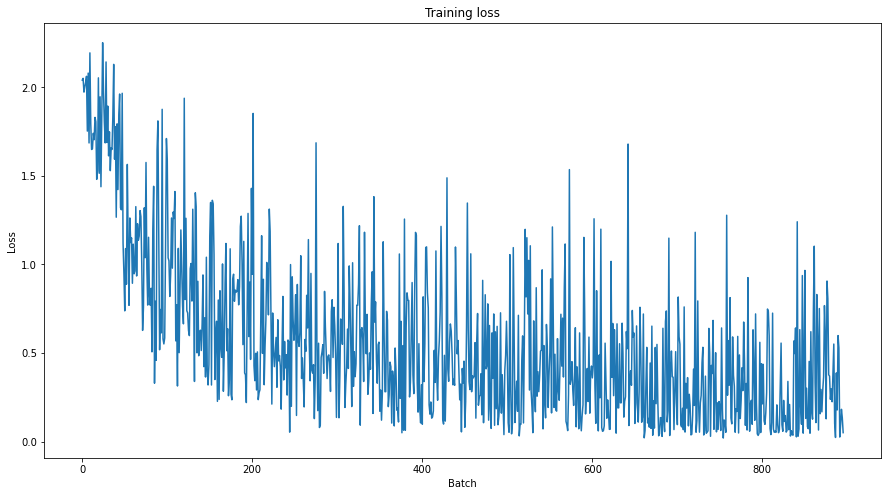

In [29]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [30]:
# Save model
model.save_pretrained("roberta-feb-15")